In [1]:
%pylab inline
import xcml
import siestah2o as h2o
import pickle
from mbpol_calculator import MbpolCalculator, reconnect_monomers
from ase import Atoms
import siesta_utils.grid as siesta
from ase.io import iread, read
import sys
sys.path.append('..')
import config as c
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [58]:
basis = 'dz_custom'
features = 'mull'
path = '/gpfs/scratch/smdick/md_siesta_mull_test/'
every = 1

In [59]:
#Load relevant models 

e_model = False
f_model = False
fd_model = False
try:
    krr_O = pickle.load(open(c.model_basepath + c.par[features]['krr_o'][basis], 'rb'))
    krr_H = pickle.load(open(c.model_basepath + c.par[features]['krr_h'][basis], 'rb'))
    f_model = True
except KeyError:
    print('No force model found')    
try:
    krr_O_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_o_dx'][basis], 'rb'))
    krr_H_dx = pickle.load(open(c.model_basepath + c.par[features]['krr_h_dx'][basis], 'rb'))
    fd_model = True
except KeyError:
    print('No finite diff. model found')
try:
    nn = xcml.load_network(c.model_basepath + c.par[features]['nn'][basis])
    e_model = True
except KeyError:
    print('No energy model found')
    


No finite diff. model found
INFO:tensorflow:Restoring parameters from /gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_dz_rand/model.ckpt


In [60]:
# Load data 

if features == 'descr':
    n_o_orb = 18
    n_h_orb = 8
else:
    n_o_orb = c.par[features]['n_o_orb'][basis]
    n_h_orb = c.par[features]['n_h_orb'][basis]
    
    
feat = np.genfromtxt(path +'/siesta/features.dat').reshape(-1, 128, n_o_orb + 2 * n_h_orb)[1:]
forces_siesta = np.genfromtxt(path +'/siesta/forces_siesta.dat').reshape(-1,128,3,3)[1:]
forces_corrected = np.genfromtxt(path + '/siesta/forces_corrected.dat').reshape(-1,128,3,3)[1:]
energies = pd.read_csv(path + '/siesta/energies.dat', delim_whitespace= True).iloc[1:]

In [61]:
# Calculate reference data 
forces_mbpol = []
energies_mbpol = []
coords = []
all_atoms = read(path + 'md_siesta.traj', '::{}'.format(every))

coor0 = np.array(all_atoms[0].get_positions())
atoms = all_atoms[0]
atoms = reconnect_monomers(atoms)
atoms = reconnect_monomers(atoms)
atoms.set_calculator(MbpolCalculator(atoms))

for a in all_atoms:
    
    atoms.set_positions(a.get_positions())
    atoms = reconnect_monomers(atoms)
    atoms = reconnect_monomers(atoms)
    coords.append(atoms.get_positions())
    energies_mbpol.append(atoms.get_potential_energy())
    forces_mbpol.append(atoms.get_forces())

In [62]:
energies_mbpol = np.array(energies_mbpol)
forces_mbpol = np.array(forces_mbpol).reshape(-1,128,3,3)
energies = energies.iloc[::every]
energies['Mbpol'] = energies_mbpol


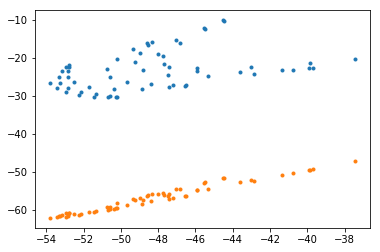

In [63]:
plot(energies['Mbpol'] , energies['Siesta'], ls = '', marker = '.')
plot(energies['Mbpol'] , energies['Corrected'], ls = '', marker = '.')

In [64]:
print(np.std(energies['Mbpol'] - energies['Siesta'])/128)
print(np.std(energies['Mbpol'] - energies['Corrected'])/128)

0.03922478010411731
0.00592141209266877


In [65]:
len(forces_siesta)

63

In [66]:
if features == 'descr':
    symmetry = np.genfromtxt('./symmetry.dat')
else:
    symmetry = 0

0.6007035725961694
0.14956486170656283
0.14956308959681253


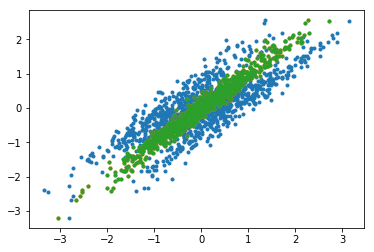

In [71]:
i = 61
corrections = xcml.use_force_model(feat[i], krr_O, krr_H, n_o_orb, n_h_orb, True, coords[i], sym = symmetry)
plot(forces_siesta[i].flatten(), forces_mbpol[i].flatten(), ls = '', marker = '.')
plot(forces_corrected[i].flatten(), forces_mbpol[i].flatten(),ls = '', marker = '.')
plot(forces_siesta[i].flatten() - corrections.flatten(), forces_mbpol[i].flatten(),ls = '', marker = '.')
print(np.std(forces_siesta[i].flatten() - forces_mbpol[i].flatten()))
print(np.std(forces_corrected[i].flatten() - forces_mbpol[i].flatten()))
print(np.std(forces_siesta[i].flatten() - corrections.flatten() - forces_mbpol[i].flatten()))